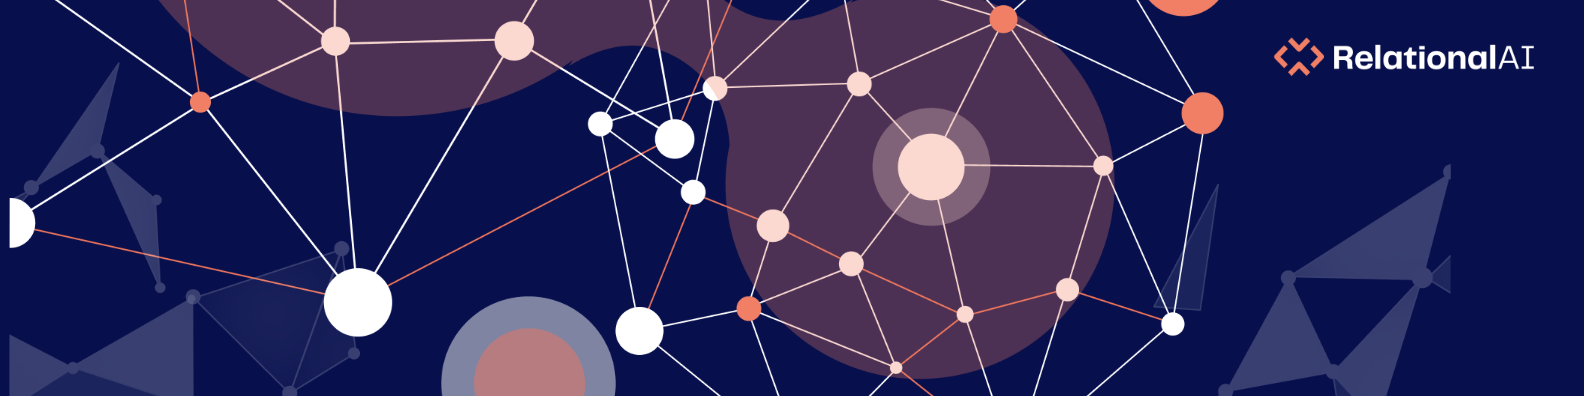

# Pagerank

The `pagerank` function computes the [pagerank](https://en.wikipedia.org/wiki/PageRank) value of a node in a graph.

PageRank measure the importance of a node based on its connections to other important nodes.

The algorithm was invented by Larry Page, co-founder of Google. Originally it was used to order search result and show the most important hits first. 
This concept revolutionized the whole field of search engines.

Let us look at a very small example graph and apply pagerank to identify the most important nodes.

First, we need to import the `relationalai` library and define our model, which we call `PageRank`.
We also create a type called `Page`. In a labelled property graph model `Page` would be translated into a node label.

In [ ]:
%pip install relationalai

In [2]:
import relationalai as rai
from relationalai.std import aggregates
from relationalai.std.graphs import Graph

model = rai.Model("PageRank")
Page = model.Type("Page")

## Let's add some data to our model

Our data model is very simplistic: it's web pages that link to other web pages. We define a dictionary of page names and the pages they are linked to. We then iterate over it to create `Page` objects with `name` property and connect them via `links` property.

In [3]:
pages_links = {
    "Startpage": ["News", "Products", "Imprint"],
    "News": ["Startpage", "Products"],
    "Products": ["Product1", "Product2", "Product3", "Startpage"],
    "Product1": ["Products", "Product2"],
    "Product2": ["Products", "Product3"],
    "Product3": ["Products"],
    "Imprint": ["Startpage"],
}

with model.rule(dynamic = True):
    for (page_name, links) in pages_links.items():
        page = Page.add(name = page_name)
        for linked_page_name in links:
            linked_page = Page.add(name = linked_page_name)
            page.links.add(linked_page)

## Creating the graph
Let's start by creating a `graph` with `Node` and `Edge` collections. We add all `Page` instances as nodes, and assign the `name` property so that we can use them in our queries and for visualization purposes. The `links` property is then used to form the edges in our graph.

In [4]:
# Create graph
graph = Graph(model)

# add all Page instances as Nodes, assign `name` property (for displaying)
graph.Node.extend(Page, name = Page.name)

# add all `links` property as Edges
graph.Edge.extend(Page.links)

## Running the algorithm
Let's add a rule that calculates for every node of the graph the pagerank value. To derive this value for each node, we can simply use `Graph(model).compute.pagerank()`.
Note that we could supply algorithm parameter like damping factor or maximum iterations. In this case we will rely on default values.

In [5]:
with model.rule():
    p = Page()
    pagerank = graph.compute.pagerank(p)
    p.set(pagerank = pagerank)
    graph.Node(p).set(pagerank = pagerank)

## Querying the Graph
Graph Nodes, Edges and their properties are queried using `model.query()` context and `graph.Node()` or `graph.Edge()` types.

Alternatively, the entire graph representation can be fetched using `Graph(model).fetch()`. This returns a dictionary with two keys, `nodes` and `edges`, that represents the entire graph. 

In [6]:
with model.query() as select:
    p = graph.Node()
    response = select(p.name, p.pagerank)

response
# fetch the entire graph dictionary (not recommended to be used for large graphs)
# graph_dict = graph.fetch()

### Ordering the pages by their pagerank

We can sort our results by applying `aggregates.rank_desc` function to see the pages starting from the highest ranking one.

In [7]:
with model.query() as select:
    p = Page()
    rank = aggregates.rank_desc(p.pagerank)
    response = select(rank, p.name, p.pagerank)

response

### Using aggregation functions
Let's calculate the total of all pagerank values. 
Pagerank is normalized - so the sum over all values is 1.0.

In [8]:
with model.query() as select:
    p = Page()
    totalPagerank = aggregates.sum(p, p.pagerank)
    response = select(totalPagerank)

response

## Visualizing the results
As a final step, let's visualize our graph, to better understand the results. We use `Graph(model).visualize()` to visualize our graph.
Note that we scale the size of the nodes to represent their pagerank. In our example the `Products` page has the highest pagerank.

In [9]:
graph.visualize(three = False, style = {
    "node": {
        "label": lambda n : n['name'],
        "color": "blue",
        "size": lambda n: n["pagerank"] * 100
    },
    "edge": {
        "color": "green",
    }
}).display(inline = True)